In [1]:
%pip install pylatexenc
# %pip install qiskit
%pip install qiskit-machine-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136833 sha256=fd5cde82b1167fe66145338518da5f7788bf7ac2d200bf3bb0932d2d24a5fcb9
  Stored in directory: /root/.cache/pip/wheels/1d/c6/5a/2b7b4933c171a55d448e0c79d5841c28cf0c2207e8eca28e22
Successfully built pylatexenc
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 58.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 27.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.

# Imports

In [2]:
import numpy as np

from qiskit import BasicAer
from qiskit.utils import QuantumInstance
# , aqua_globals
from qiskit_machine_learning.algorithms import VQC
from qiskit.algorithms.optimizers import SPSA, COBYLA,SLSQP
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, RealAmplitudes
# from qiskit.utils import  split_dataset_to_data_and_labels, map_label_to_class_name
from sklearn.model_selection import train_test_split
from qiskit.utils import quantum_instance
from qiskit.utils import algorithm_globals
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pylatexenc

seed = 10599
algorithm_globals.random_seed = seed

# Data

First, we generate a toy dataset that can be fully separated with `qiskit.circuit.library.ZZ_Feature_Map` as the feature map circuit (later we will discuss it).

Ref:

>https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.datasets.ad_hoc_data.html

>https://qiskit.org/documentation/stable/0.24/apidoc/qiskit.ml.datasets.html

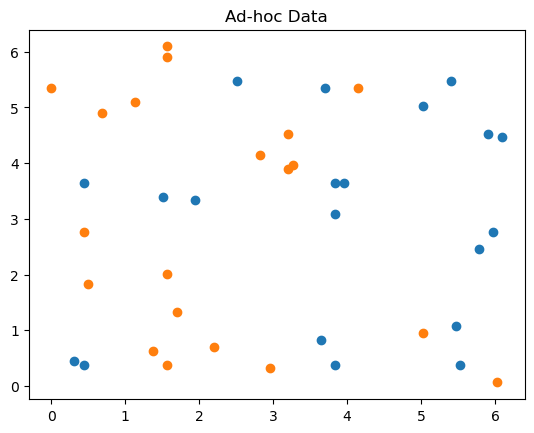

In [3]:
from qiskit_machine_learning.datasets import ad_hoc_data

feature_dim = 2
train_input, train_labels, test_input, test_labels = ad_hoc_data(
    training_size=20,
    test_size=10,
    n=feature_dim,
    gap=0.3,
    plot_data=True
)

X = np.append(train_input, test_input, axis=0)
Y = np.append(train_labels, test_labels, axis=0)[:,1]


In [4]:
print(train_input.shape)
print(train_labels.shape)
print(test_input.shape)
print(test_labels.shape)

(40, 2)
(40, 2)
(20, 2)
(20, 2)


In [10]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [6]:
num_inputs = 2
num_samples = len(train_input)
# construct feature map, ansatz, and optimizer

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
ansatz = RealAmplitudes(num_inputs, reps=1)

###  Feature Map Circuit $V(x)$


The feature map circuit is an intermediate circuite to encode input data and map be the Ansatz for variational circuit. In Terra Circuit Library of Qiskit, there are various feature maps can be used. Some of the main circuits are:

    - ZFeatureMap
    - ZZFeatureMap
    - PauliFeatureMap

Generally, the feature map consists of several cascaded circuits written in this form:

$\mathrm{V}(x)=V_M\left(x_M\right) V_{M-1}\left(x_{M-1}\right) \ldots V_1\left(x_1\right) \quad$ (Feature Map)

**ZZFeatureMap function Arguments**

>feature_dimensions: dimensionality of the classical data (equal to the number of required qubits)

>reps: number of times the feature map circuit is repeated

>data_map_function: function encoding the classical data.

>entanglement: generates connectivity `full` or `linear` or defining customized entanglement structure

Ref:

>Terra Circiut Library:
>https://qiskit.org/documentation/apidoc/circuit_library.html


     ┌───┐┌─────────────┐                                          ┌───┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
«     ┌─────────────┐                                          
«q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──
«     ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐
«q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └─────────────┘└───┘└──────────────────────────────┘└───┘


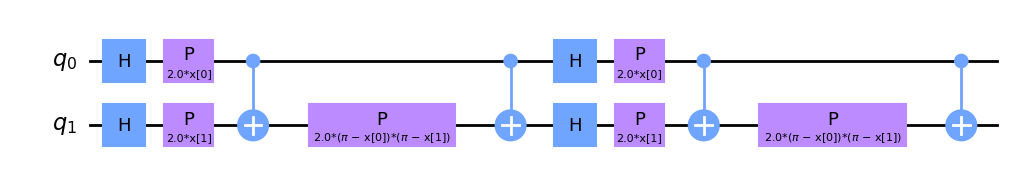

In [7]:
print(feature_map.decompose())
feature_map.decompose().draw("mpl")

###  Variational Circuit $U(\theta)$
A variational (ansatz) circuit is a parameterized circuit, say $U(\theta)$ where $θ$ are a set of parameters, used to prepare a trial state in the form of trainable parameters for the problem: 

$$\mathrm{U}(\theta)=U_L\left(\theta_L\right) U_{L-1}\left(\theta_{L-1}\right) \ldots U_1\left(\theta_1\right) \quad$$

$\mathrm{U}_i\left(\theta_i\right)$ consists of building blocks of : $R_x(\theta), R_y(\theta), R_z(\theta), C N O T, C Z$, where $\theta$ is the vector of "rotational angles".

Applying the ansatz circuit to the set of input states, will give us the output of the QNN with observables:

$$|\Psi(\theta)\rangle = U(\theta)|0\rangle$$

Finally by measuring expectation values and estimating the rotation angles, the observables are calculated and feed to the classical optimizer

$$
M=\left\langle\psi_0\left|V^{\dagger}\left(x^{(i)}\right) U^{\dagger}(\theta) \mathrm{U}(\theta) V(x)\right| \psi_0\right\rangle
$$



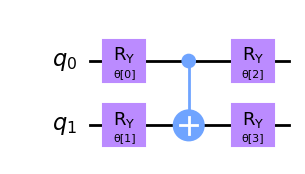

In [8]:
ansatz.decompose().draw("mpl")

# Optimization

In a variational algorithm, such as VQE, the trial state encodes the solution using optimization methods and parameters $θ$ are iteratively updated until they meet a termination criterion. 

$|\Psi(\theta_0)\rangle \rightarrow |\Psi(\theta_1)\rangle \rightarrow \dots \rightarrow |\Psi(\theta_n)\rangle$

## A. The Loss Function

### A.1. L2 Loss (Mean Squared Error)
L2 loss, also known as Squared Error Loss, is the squared difference between a prediction and the actual value, calculated for each example in a dataset. The aggregation of all these loss values is called the cost function, where the cost function for L2 is commonly MSE (Mean of Squared Errors)

As we see in the slide, the loss function for MSE can be described as below equation for our desinged QNN:

$\mathrm{C}(\theta)=\sum_i\left[y^{(i)}-\left\langle\psi_0\left|V^{\dagger}\left(x^{(i)}\right) U^{\dagger}(\theta) A U(\theta) V\left(x^{(i)}\right)\right| \psi_0\right\rangle\right]^2$



### A.2. Cross Ontropy

Ref:

> https://qiskit.org/ecosystem/machine-learning/apidocs/qiskit_machine_learning.utils.loss_functions.html


## B. The Optimizer

A classical optimization routine changes the values of the whole circuit and repeats the whole process again, when we get the prediction in each iteration. One popular approach to perform the optimization is, Gradient-descent with learning rate $\gamma$ as follow:
$$
\theta^{t+1}=\theta^t-\gamma \nabla_\theta \mathrm{C}
$$


The loop is repeatedly performing to get a lower value for the cost function and resulting in higher accuracy.

There are three main types of Optimizers:

    COBYLA (Constrained Optimization By Linear Approximation optimizer)
    SPSA (Simultaneous Perturbation Stochastic Approximation optimizer)
    SLSQP (Sequential Least Squares Programming optimize)

### B.1. COBYLA Optimizer

COBYLA (Constrained Optimization By Linear Approximation optimizer) is one of the powerful numerical optimization method for constrained problems where the derivative of the objective function is not known.

Ref:

> https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/algorithms/optimizers/cobyla.py

> https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

> https://qiskit.org/documentation/stable/0.24/apidoc/qiskit.aqua.components.optimizers.html

#### COBYLA with "squared_error" Implementation

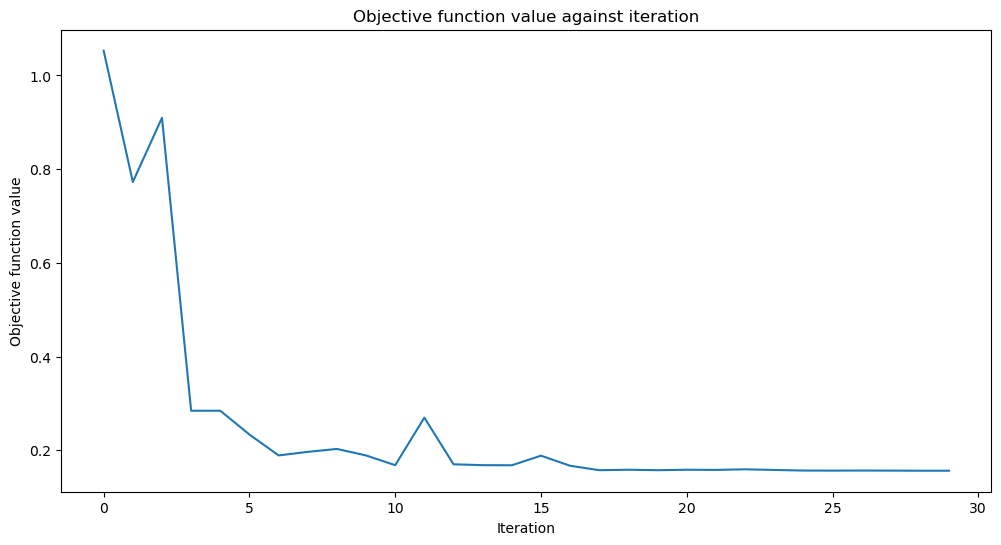

0.85

In [11]:
# construct variational quantum classifier

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="squared_error", # L2 Loss (Mean Square Error)
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(train_input, train_labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(test_input, test_labels)

#### COBYLA with "cross_entropy" Implementation

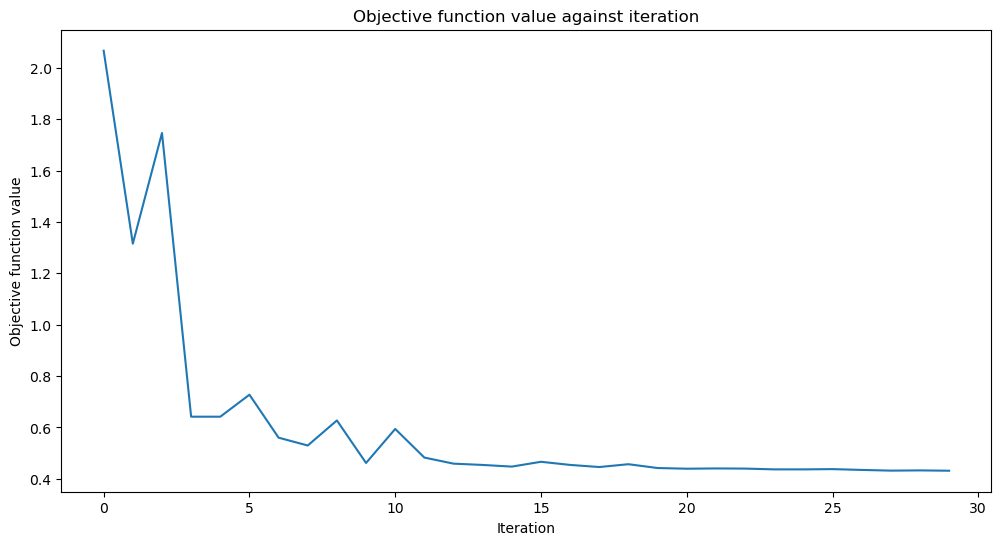

0.8

In [12]:
# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(train_input, train_labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(test_input, test_labels)

#### SLSQP with "squared_error" Implementation

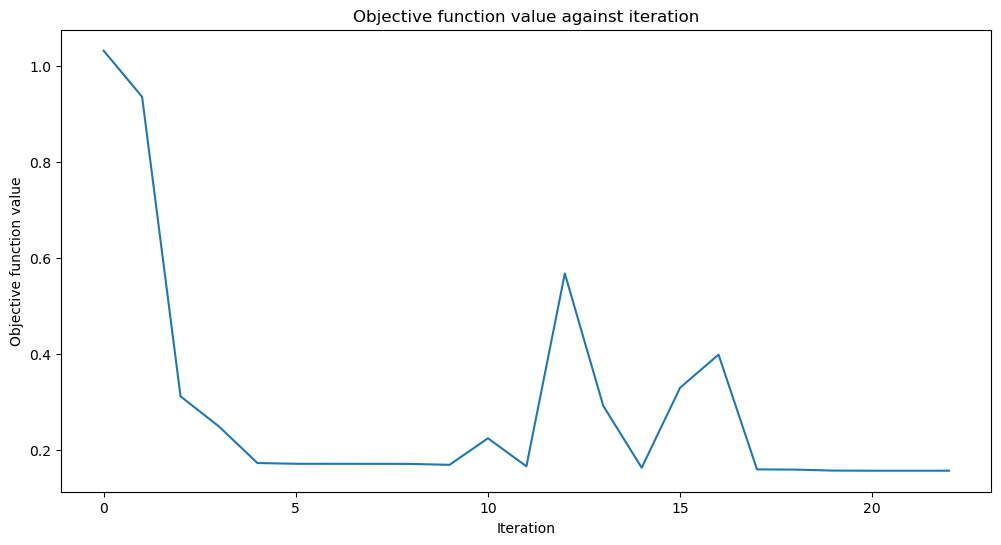

0.8

In [13]:
from qiskit.algorithms.optimizers import SPSA, COBYLA, SLSQP

# construct feature map, ansatz, and optimizer
# https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/algorithms/optimizers/cobyla.py

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="squared_error", # L2 Loss (Mean Square Error)
    optimizer=SLSQP(maxiter=30),
    callback=callback_graph,
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(train_input, train_labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(test_input, test_labels)

# Visualization

In this section we visualize the classification results and the boundary line (defined by a classical SVC algorithm).

The small dots are referring to the training samples and the regular dots refer to the test samples. Note that the red circles have been plotted to show the wrong predictions of test samples.

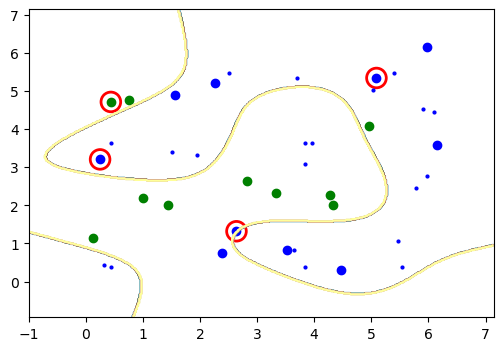

In [14]:
import scipy
from sklearn import svm

# evaluate data points
y_predict = vqc.predict(test_input)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(test_input, test_labels, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)

for x, y_target, y_p in zip(train_input, train_labels, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo", markersize=2)
    else:
        plt.plot(x[0], x[1], "go", markersize=2)



C = 500.0  # SVM regularization parameter
clf = svm.SVC(kernel = 'rbf',  gamma=0.1, C=C )
clf.fit(X, Y)

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

plt.show()
